# Deep Learning
## Assignment 5

The goal of this assignment is to train a Word2Vec skip-gram model over Text8 data.

In [21]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary. The data was part of wikipedia, but had been preprocessed, for example, punctuations removed, cases transformed.

In [22]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [23]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [24]:
words[:20]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english']

Build the dictionary and replace rare words with UNK token.

In [25]:
vocabulary_size = 50000
#Fetch 50000 words from the original data set
def build_dataset(words):
  #Set the first word as 'UNK'
  count = [['UNK', -1]]
  #Calculate the frequencies of words and select the most frequent 50000 ones
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  #Encode the frequent 50000 words with index in the dictionaray
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  #Encode the rare words with 'UNK'
  #Encode each word with its index
  data = list()
  unk_count = 0
  for word in words:
    #If the word is frequent
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    #Store the index for each word
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [26]:
reverse_dictionary[5239]

'anarchism'

In [27]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  '''
  batch_size: the number of batch words
  num_skips: number of words used to make predictions, usually euqal to 2*skip_window
  skip_window: number of left or right words used to predict the target world
  '''
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)#A quene with maximum size of span
  #Get the indices of words within a span
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ] #Record the words selected
    for j in range(num_skips):
      #Randomly choose an unselected word
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      #Find the context of the center word
      batch[i * num_skips + j] = buffer[skip_window]#The center word
      labels[i * num_skips + j, 0] = buffer[target]#The left and right words of center word
    #Shift the index to next word
    buffer.append(data[data_index])#Note, buffer's size remain as span
    data_index = (data_index + 1) % len(data)#The index won't o out of scope
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:16]])
bs = 16
for num_skips, skip_window in [(2, 1), (8, 4)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=bs, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(bs)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used']
    labels: ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'of', 'a', 'term', 'abuse', 'of', 'first', 'abuse', 'used', 'against', 'first']

with num_skips = 8 and skip_window = 4:
    batch: ['term', 'term', 'term', 'term', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of']
    labels: ['of', 'used', 'originated', 'as', 'a', 'anarchism', 'abuse', 'first', 'abuse', 'term', 'first', 'a', 'as', 'against', 'originated', 'used']


Train a skip-gram model.

In [28]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph1 = tf.Graph()

with graph1.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  #Encoding the all the words into vectors, V*M, V is vocabulary size
  #M is encoding size
  #Initalize them in a form of uniform distribution
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  #Assistant vectors for each word
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs, select those vectors for input words.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  # Those words which are not the output can be viewed as negative labels
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [29]:
num_steps = 40001

with tf.Session(graph=graph1) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.208791
Nearest to many: troubadors, halfbakery, lash, ech, cuar, shipwrecked, largo, parables,
Nearest to by: cheka, derrick, paran, temporal, russo, pins, roosevelt, folk,
Nearest to or: modernizing, heterotic, formalized, gaff, keefe, rendezvous, employed, strangled,
Nearest to a: monsignor, swearing, scandals, naturally, shirt, eldest, clocks, exemption,
Nearest to so: tribunal, dismissing, aces, adamson, integrative, sergius, cartoonists, knoll,
Nearest to not: reasoning, nostalgia, walrus, circumnavigated, underdogs, endanger, humanists, overflowing,
Nearest to war: cddb, abdulaziz, exchanges, addington, expense, islas, door, watson,
Nearest to known: insulinotherapy, classic, robotech, litigation, osiris, dominatrices, hastened, barbiturates,
Nearest to which: navigation, bitrates, racehorse, despotism, pointless, munch, canaanites, fitzroy,
Nearest to they: insulator, unter, ogilvie, homosexuals, escalated, controlling, romanian, hermitian,


In [30]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

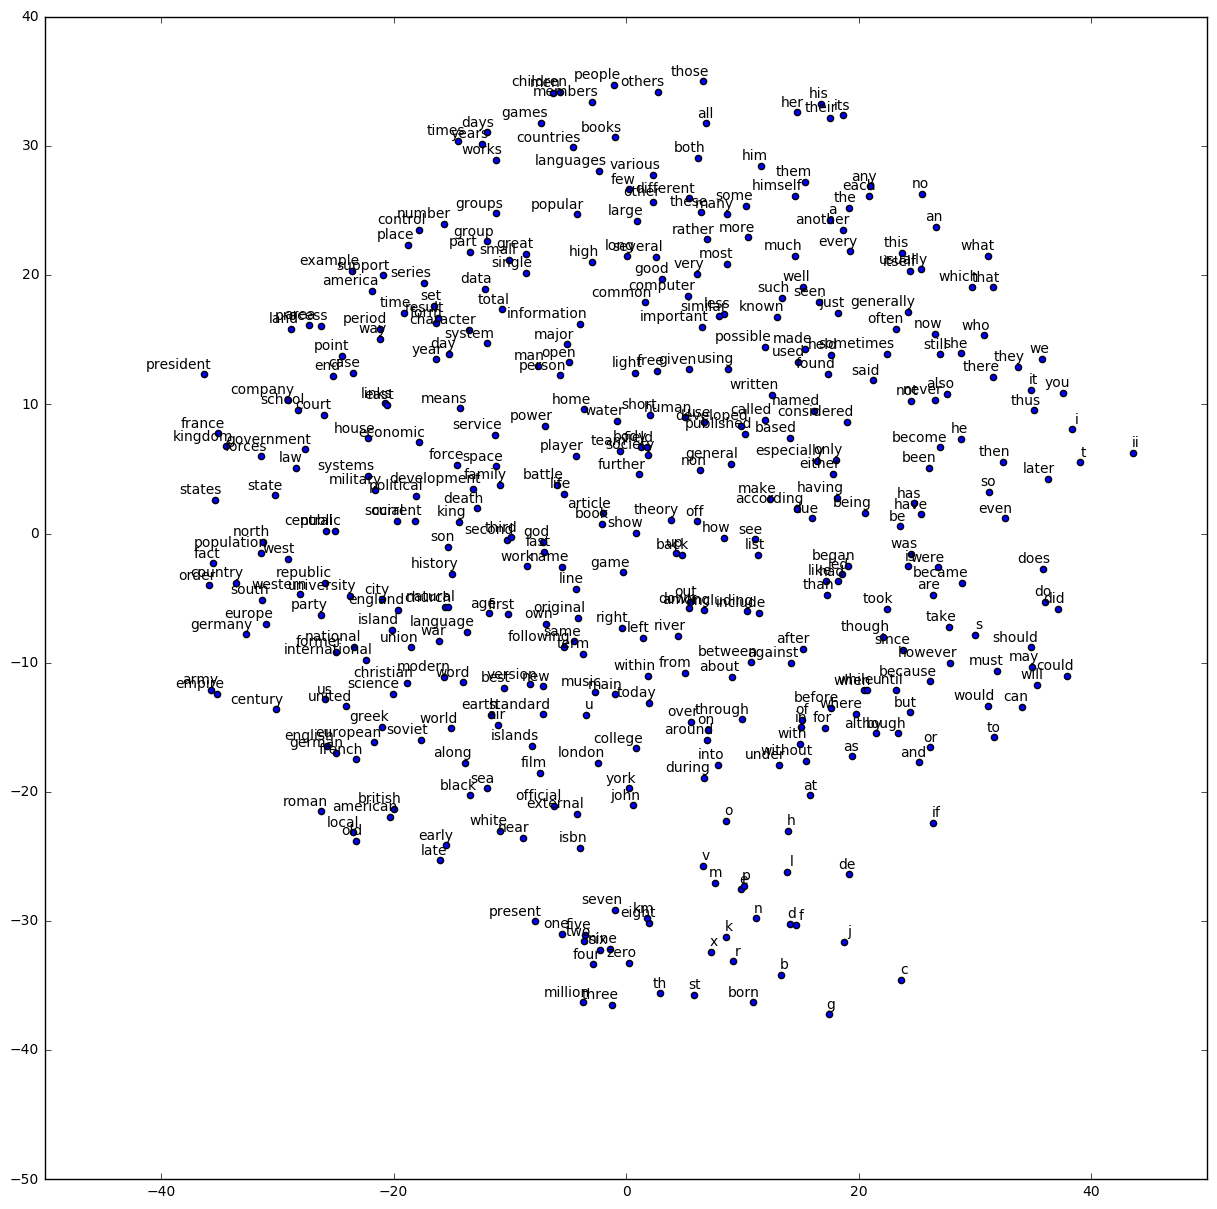

In [31]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

## Problem
An alternative to skip-gram is another Word2Vec model called CBOW (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

In [32]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  #Get the indices of words within a span
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      #batch[i * num_skips + j] = buffer[skip_window]
      #labels[i * num_skips + j, 0] = buffer[target]
      batch[i * num_skips + j] = buffer[target]
      labels[i * num_skips + j, 0] = buffer[skip_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'of', 'a']
    labels: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']

with num_skips = 4 and skip_window = 2:
    batch: ['a', 'anarchism', 'originated', 'term', 'term', 'as', 'originated', 'of']
    labels: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']


In [33]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph2 = tf.Graph()

with graph2.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  #Encoding the words into vectors
  #Initalize them in a form of uniform distribution
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [34]:
num_steps = 40001

with tf.Session(graph=graph2) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.859468
Nearest to who: spoofed, exam, revoke, kaye, copy, started, bearers, palestinian,
Nearest to he: forsyth, oeuvre, coon, dyes, southern, nuanced, nanoscale, round,
Nearest to one: presidents, almost, survivability, ves, borrowed, reinforces, prediction, bithynia,
Nearest to states: hooker, canoes, defect, amour, shovel, acoustical, mvd, patiently,
Nearest to united: typically, osteoporosis, bleue, wff, scopes, stephanie, databases, lapse,
Nearest to has: cromwell, persistence, dmz, marmalade, shield, southwestern, servicio, redefined,
Nearest to after: nail, jarman, dolphins, paper, leap, agnetha, vengeful, essay,
Nearest to only: siberia, multilateral, bellarmine, erect, synthesizers, kmt, diocese, preoccupied,
Nearest to or: aerosols, wanna, variegated, hw, swordsman, conformational, redstone, miggins,
Nearest to which: cleveland, rdos, omnibus, lies, theatres, jordi, weizenbaum, productive,
Nearest to on: containment, evaporative, nh, disp

In [37]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

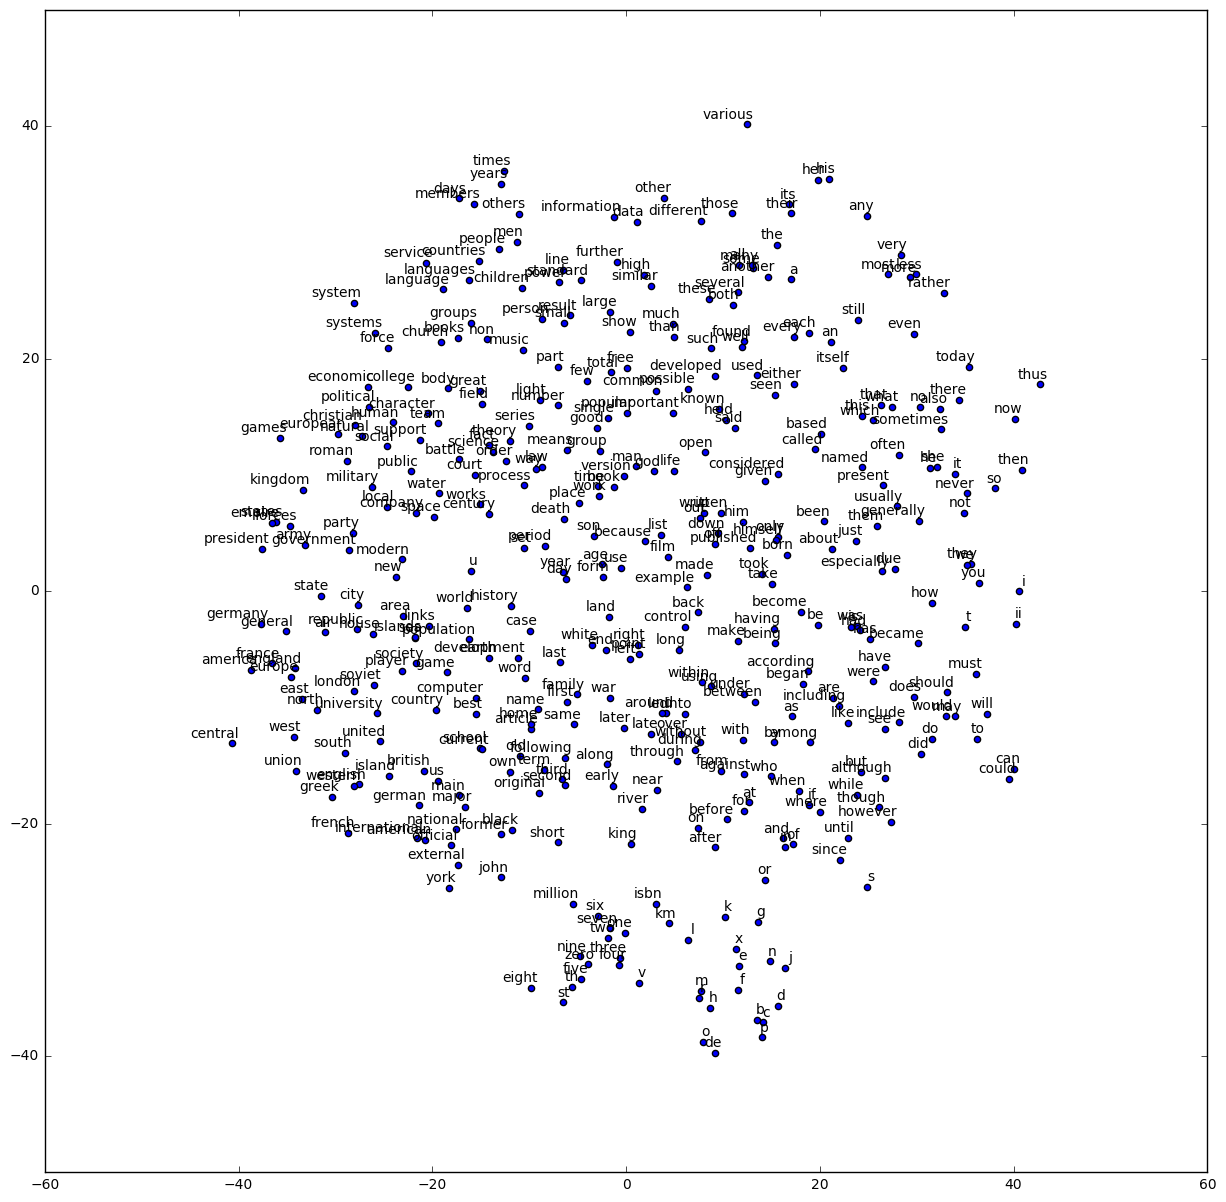

In [38]:
words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

You can see that the numbers are close to each other.